# CNN+LSTM and Learning Rate sweep on Synthetic Time Series Dataset:


Coursera Colab Link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Lesson%201.ipynb

LSTM Andrew Ng:  https://www.coursera.org/lecture/nlp-sequence-models/long-short-term-memory-lstm-KXoay

- We add a Convolution 1D layer at the beginning.
- RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
- However, we won't use a Lambda layer to expand the dims but we'll do it in the dataset preparation function. Since our dataset is 2D [batch_size, window_size], we'll have to expand using tf.exapnd_dims.
- RNN only outputs the last sequence (last time step) by default, if we want to get the output for all the sequences (all time steps) to feed it into a lower RNN, we need to use return_sequences=True.
- RNN use 'tanh' as activation function by default.
- Simple RNN use the output as the state vector recurred (fed back) to the next time step.
- LSTM carry a cell state from step 0 to the end time step in order that initial information has bigger impact on latter time steps than on the simple RNN.
- Bidirectional then carries info from 0 to end and then from end to 0.

TF Keras Conv1D: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

TF Keras LSTM: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

TF Keras DNN: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense


mini-batch gradient descent Andrew Ng: https://www.youtube.com/watch?v=4qJaSmvhxi8

Huber loss function: https://en.wikipedia.org/wiki/Huber_loss

Lambda tf keras layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda

tf.expand_dims: https://www.tensorflow.org/api_docs/python/tf/expand_dims


TF Dataset: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

np.newaxis: https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae

Keras Callbacks: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2.2.0-rc2


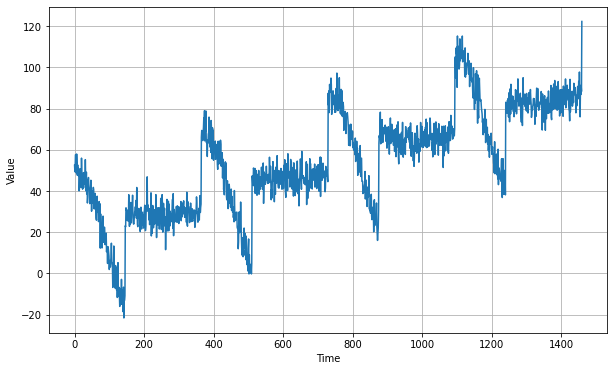

In [0]:
# Creating a synthetic Time Series:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
# Spliting the data into Training and Validation sets:

time_split = 1000

time_train = time[:time_split]
x_train = series[:time_split]

time_val = time[time_split:]
x_val = series[time_split:]

In [0]:
# Parameters for preparing the dataset ready for ML:

window_size = 30  # window_size is the number of features!
batch_size = 128
shuffle_buffer_size = 1000

# Conv1D+LSTM Model with fixed learning rate:

In [0]:
# Function to window + capping + flattening + splitting + batching the dataset:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size) :
  series = tf.expand_dims(series, axis=-1)                                            # With Conv1D we expand the dimension of the dataset here instead of with a Lambda layer!!!
  dataset = tf.data.Dataset.from_tensor_slices(series)                                # create a tf dataset. we import the time series into tensorflow dataset using from_tensor_slices
  dataset = dataset.window(size=window_size + 1, shift = 1, drop_remainder=True)      # slice the dataset by windows. we add +1 into window_size as the additional one will be used as label!!!
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))              # flatten the data out to be easier to work with. we flatten the data into chuncks of the size of window_size+1
  dataset = dataset.shuffle(shuffle_buffer_size)                                      # once flattened it is easy to shuffle the order of the windows. it picks large dataset by groups of shuffle_buffer_size and then takes random samples. This speeds up the random shuffling in large datasets.
  # dataset = dataset.map(lambda window: (window[:-1], window[-1:]))                    # splitting the data into features and labels (last one) using map and lambda function. this is stored in tuples.
  dataset = dataset.map(lambda window: (window[:-1], window[1:]))                     # !!! careful !!! if we returen sequences from the LSTM labels need to be from 1: on not just the last one!!!
  dataset = dataset.batch(batch_size).prefetch(1)                                     # the split dataset is batched in batches of the specified size.

  return dataset

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=5,     # 32 filters of chuncks of 5 of each sequence.
                                 strides=1, padding='causal',   # stride length of the conv; 'padding causal' results in causal (dilated) convolutions, e.g. `output[t]` does not depend on `input[t+1:]`. Useful when modeling temporal data where the model should not violate the temporal order.
                                 activation='relu',
                                 input_shape=[None,1]))         # dataset dim is already augmented before, hence the [None, 1]
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.LSTM(10, activation='relu', input_shape=[None, 1]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another LSTM, GRU or RNN underneath.
# model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
model.add(tf.keras.layers.Lambda(lambda x : x * 200.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

# model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae','mse','accuracy'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
dense (Dense)                (None, None, 1)           65        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 41,729
Trainable params: 41,729
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the model:

history =  model.fit(train_dataset, epochs=50, verbose=1)

Epoch 1/50
8/8 [==============================] - 0s 43ms/step - loss: 61.3439 - mae: 62.7424 - mse: 5478.7451 - accuracy: 0.0000e+00
Epoch 2/50
8/8 [==============================] - 0s 44ms/step - loss: 39.3000 - mae: 40.0914 - mse: 2257.8398 - accuracy: 0.0000e+00
Epoch 3/50
8/8 [==============================] - 0s 44ms/step - loss: 28.0999 - mae: 28.6880 - mse: 1288.6831 - accuracy: 0.0000e+00
Epoch 4/50
8/8 [==============================] - 0s 41ms/step - loss: 23.4014 - mae: 23.9319 - mse: 915.9523 - accuracy: 0.0000e+00
Epoch 5/50
8/8 [==============================] - 0s 42ms/step - loss: 20.0599 - mae: 20.6316 - mse: 706.9042 - accuracy: 0.0000e+00
Epoch 6/50
8/8 [==============================] - 0s 42ms/step - loss: 17.9843 - mae: 18.5284 - mse: 589.5511 - accuracy: 0.0000e+00
Epoch 7/50
8/8 [==============================] - 0s 42ms/step - loss: 16.4279 - mae: 16.8838 - mse: 521.2565 - accuracy: 0.0000e+00
Epoch 8/50
8/8 [==============================] - 0s 42ms/step - l

In [0]:
# Function to performn the forecasting for us after training:

def model_forecast(model, series, window_size) :
  ds = tf.data.Dataset.from_tensor_slices(series)                    # create a tf dataset
  ds = ds. window(size=window_size, shift = 1, drop_remainder=True)  # no need to add the window_size + 1 here as for predicting we don't add the label!
  ds = ds.flat_map(lambda window: window.batch(window_size) )        # we flatten the data into chunks of window_size
  ds = ds.batch(32).prefetch(1)                     # the split dataset is batched in batches of the specified size.
  forecast = model.predict(ds)

  return forecast


1442
[[[45.415565]
  [53.047115]
  [47.502728]
  [53.26709 ]
  [51.046032]
  [47.462246]
  [47.3712  ]
  [49.093094]
  [48.822624]
  [49.643356]
  [49.794445]
  [49.759598]
  [49.808075]
  [50.696053]
  [48.953823]
  [47.483234]
  [48.046764]
  [48.728268]
  [48.578724]
  [45.390633]]

 [[45.81324 ]
  [53.934402]
  [49.524277]
  [51.34501 ]
  [47.524117]
  [46.40855 ]
  [47.838696]
  [47.721775]
  [48.37034 ]
  [48.43843 ]
  [48.627274]
  [48.820583]
  [49.745213]
  [48.095993]
  [46.324833]
  [46.768684]
  [47.601627]
  [48.36484 ]
  [46.39673 ]
  [46.237106]]]


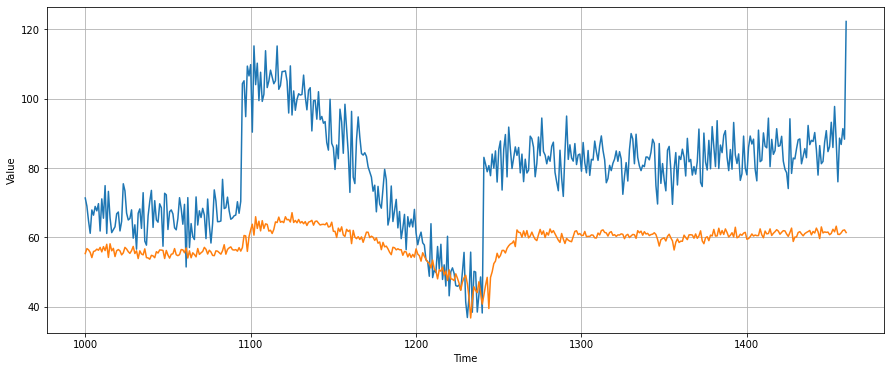

In [0]:
# Prediction of all elements of the validation set:

# Calculating predictions by picking up slices of window_size each time:
forecast = model_forecast(model, series[..., np.newaxis], window_size)   # remember that we need to expand the dim of the dataset. Here we use np.newaxis

print(len(forecast))
print(forecast[:2])

# Getting the predictions of the validation set only
forecast = forecast[time_split-window_size:-1, -1, 0]  # !!! Careful here!!! -> the predictions index are shifted by window_size
                                                       # use this if we carry all the sequences from the LSTM (return_sequences=True on all the LSTM layers). as you want only the last time step.
# forecast = forecast[time_split-window_size:-1, 0, 0]   # use this if we carry only the last time step from the LSTM (no return_sequences=True on the last LSTM). as it outputs only the last and only time step.                                                   
results = forecast # np.array(forecast)[:,0,0]  

plt.figure(figsize=(15,6))

plot_series(time_val, x_val)
plot_series(time_val, results)
plt.show()


In [0]:
# Prediction statistical Metrics:

print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

536.58075
20.308172


# Conv1D+LSTM with learning rate sweep:

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=5,     # 32 filters of chuncks of 5 of each sequence.
                                 strides=1, padding='causal',   # stride length of the conv; 'padding causal' results in causal (dilated) convolutions, e.g. `output[t]` does not depend on `input[t+1:]`. Useful when modeling temporal data where the model should not violate the temporal order.
                                 activation='relu',
                                 input_shape=[None,1]))         # dataset dim is already augmented before, hence the [None, 1]
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.LSTM(10, activation='relu', input_shape=[None, 1]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another LSTM, GRU or RNN underneath.
# model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
model.add(tf.keras.layers.Lambda(lambda x : x * 200.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

# model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae','mse','accuracy'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
dense (Dense)                (None, None, 1)           65        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 41,729
Trainable params: 41,729
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Callback to adapt the Learning Rate:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)



# Training the model:

history =  model.fit(train_dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
8/8 [==============================] - 0s 44ms/step - loss: 74.2268 - mae: 74.5339 - mse: 7401.4761 - accuracy: 0.0000e+00 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 42ms/step - loss: 73.6265 - mae: 73.9649 - mse: 7296.1421 - accuracy: 0.0000e+00 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 43ms/step - loss: 72.5699 - mae: 73.0460 - mse: 7126.9321 - accuracy: 0.0000e+00 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 41ms/step - loss: 71.3136 - mae: 71.8989 - mse: 6919.4390 - accuracy: 0.0000e+00 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 44ms/step - loss: 70.0650 - mae: 70.5491 - mse: 6678.3335 - accuracy: 0.0000e+00 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 43ms/step - loss: 68.5073 - mae: 68.9819 - mse: 6401.4829 - accuracy: 0.0000e+00 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 43ms/step - loss: 66.6706 - mae: 6

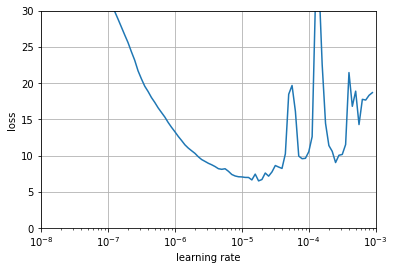

In [0]:
# Plotting the loss history vs learning rate:

lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 30])
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.grid()
plt.show()

# Re-training the Conv1D+BiDirLSTM with the best Learning Rate

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=5,     # 32 filters of chuncks of 5 of each sequence.
                                 strides=1, padding='causal',   # stride length of the conv; 'padding causal' results in causal (dilated) convolutions, e.g. `output[t]` does not depend on `input[t+1:]`. Useful when modeling temporal data where the model should not violate the temporal order.
                                 activation='relu',
                                 input_shape=[None,1]))         # dataset dim is already augmented before, hence the [None, 1]
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.LSTM(10, activation='relu', input_shape=[None, 1]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another LSTM, GRU or RNN underneath.
# model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
model.add(tf.keras.layers.Lambda(lambda x : x * 200.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

# model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae','mse','accuracy'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
dense (Dense)                (None, None, 1)           65        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 41,729
Trainable params: 41,729
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the model:

history =  model.fit(train_dataset, epochs=400, verbose=1)

Epoch 1/400
8/8 [==============================] - 0s 45ms/step - loss: 46.4651 - mae: 47.2726 - mse: 3379.1765 - accuracy: 0.0000e+00
Epoch 2/400
8/8 [==============================] - 0s 44ms/step - loss: 23.3131 - mae: 24.1494 - mse: 933.7568 - accuracy: 0.0000e+00
Epoch 3/400
8/8 [==============================] - 0s 44ms/step - loss: 13.5335 - mae: 14.0319 - mse: 364.9130 - accuracy: 0.0000e+00
Epoch 4/400
8/8 [==============================] - 0s 44ms/step - loss: 9.9285 - mae: 10.4353 - mse: 213.0049 - accuracy: 0.0000e+00
Epoch 5/400
8/8 [==============================] - 0s 42ms/step - loss: 8.2574 - mae: 8.7404 - mse: 170.1209 - accuracy: 0.0000e+00
Epoch 6/400
8/8 [==============================] - 0s 43ms/step - loss: 7.6944 - mae: 8.1897 - mse: 146.4269 - accuracy: 0.0000e+00
Epoch 7/400
8/8 [==============================] - 0s 43ms/step - loss: 7.3067 - mae: 7.7751 - mse: 137.5322 - accuracy: 0.0000e+00
Epoch 8/400
8/8 [==============================] - 0s 46ms/step - lo

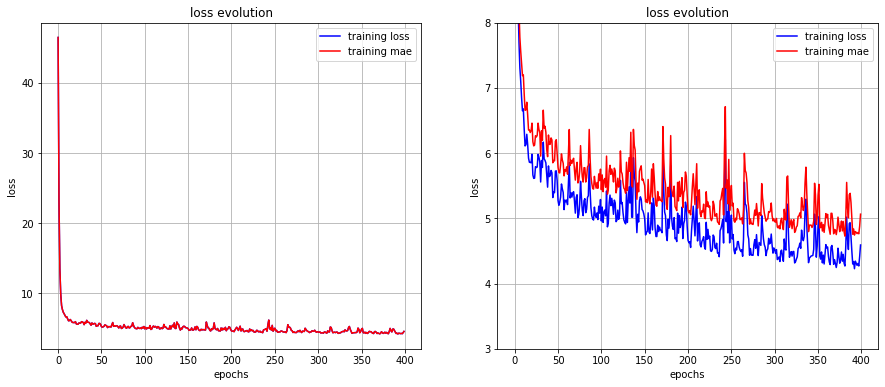

In [0]:
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(loss, 'b', label='training loss')
plt.plot(mae, 'r', label='training mae')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss evolution')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'b', label='training loss')
plt.plot(mae, 'r', label='training mae')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim((3, 8))
plt.title('loss evolution')
plt.legend()

plt.show()

print('with Bi-directional LSTM shows too noisy data -> change batch size?')

1442
[[[49.102383]
  [48.78047 ]
  [49.37013 ]
  [48.742805]
  [49.098026]
  [48.610588]
  [48.657787]
  [48.0427  ]
  [47.867577]
  [47.932377]
  [47.50254 ]
  [47.673817]
  [47.87868 ]
  [47.363213]
  [47.771027]
  [47.508312]
  [46.589535]
  [47.181004]
  [46.617023]
  [47.929893]]

 [[49.11791 ]
  [49.37515 ]
  [49.646797]
  [50.488865]
  [48.7006  ]
  [49.060966]
  [48.79661 ]
  [48.625195]
  [48.673885]
  [48.313236]
  [48.537506]
  [48.85098 ]
  [48.51074 ]
  [49.076397]
  [48.984623]
  [48.155167]
  [48.63876 ]
  [47.985756]
  [48.551357]
  [49.12708 ]]]


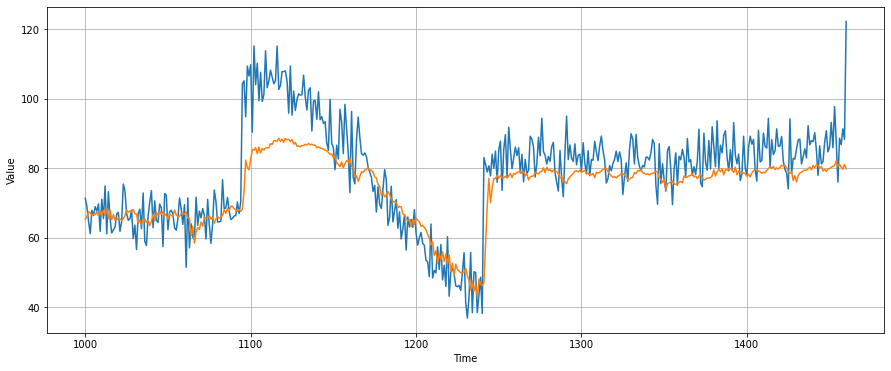

In [0]:
# Prediction of all elements of the validation set:

# Calculating predictions by picking up slices of window_size each time:
forecast = model_forecast(model, series[..., np.newaxis], window_size)   # remember that we need to expand the dim of the dataset. Here we use np.newaxis

print(len(forecast))
print(forecast[:2])

# Getting the predictions of the validation set only
forecast = forecast[time_split-window_size:-1, -1, 0]  # !!! Careful here!!! -> the predictions index are shifted by window_size
                                                       # us this if we carry all the sequences from the LSTM (return_sequences=True on all the LSTM layers). as you want only the last time step.
# forecast = forecast[time_split-window_size:-1, 0, 0]   # us this if we carry only the last time step from the LSTM (no return_sequences=True on the last LSTM). as it outputs only the last and only time step.                                                   
results = forecast # np.array(forecast)[:,0,0]  

plt.figure(figsize=(15,6))

plot_series(time_val, x_val)
plot_series(time_val, results)
plt.show()

In [0]:
# Prediction statistical Metrics:

print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

print('validation mae is way higher than training mae -> suggest changing batch size!')

84.11678
6.823937


# Re-training the Conv1D+OneWayLSTM with the best Learning Rate

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

batch_size=128

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3,     # 32 filters of chuncks of 3 of each sequence. kernel size of 3 seems smoother than 5.
                                 strides=1, padding='causal',   # stride length of the conv; 'padding causal' results in causal (dilated) convolutions, e.g. `output[t]` does not depend on `input[t+1:]`. Useful when modeling temporal data where the model should not violate the temporal order.
                                 activation='relu',
                                 input_shape=[None,1]))         # dataset dim is already augmented before, hence the [None, 1]
model.add(tf.keras.layers.LSTM(32, return_sequences=True))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.LSTM(10, activation='relu', input_shape=[None, 1]))
model.add(tf.keras.layers.LSTM(32, return_sequences=True))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another LSTM, GRU or RNN underneath.
# model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
model.add(tf.keras.layers.Lambda(lambda x : x * 200.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

# model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae','mse','accuracy'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          128       
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 16,801
Trainable params: 16,801
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the model:

history =  model.fit(train_dataset, epochs=400, verbose=1)

Epoch 1/400
8/8 [==============================] - 0s 26ms/step - loss: 36.1690 - mae: 37.1955 - mse: 2216.9941 - accuracy: 0.0000e+00
Epoch 2/400
8/8 [==============================] - 0s 24ms/step - loss: 19.2906 - mae: 19.9353 - mse: 593.7437 - accuracy: 0.0000e+00
Epoch 3/400
8/8 [==============================] - 0s 25ms/step - loss: 13.5411 - mae: 14.0907 - mse: 337.1491 - accuracy: 0.0000e+00
Epoch 4/400
8/8 [==============================] - 0s 24ms/step - loss: 11.1870 - mae: 11.7088 - mse: 230.0706 - accuracy: 0.0000e+00
Epoch 5/400
8/8 [==============================] - 0s 27ms/step - loss: 9.2533 - mae: 9.7536 - mse: 187.1254 - accuracy: 0.0000e+00
Epoch 6/400
8/8 [==============================] - 0s 24ms/step - loss: 8.0990 - mae: 8.6009 - mse: 153.0391 - accuracy: 0.0000e+00
Epoch 7/400
8/8 [==============================] - 0s 26ms/step - loss: 7.6978 - mae: 8.1751 - mse: 134.7885 - accuracy: 0.0000e+00
Epoch 8/400
8/8 [==============================] - 0s 25ms/step - l

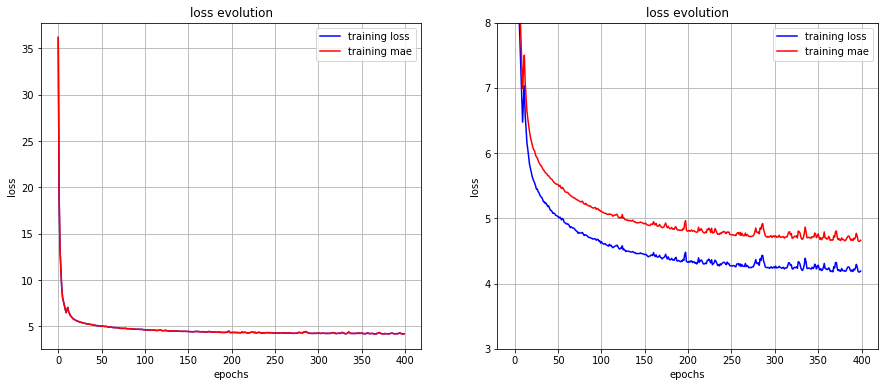

In [0]:
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(loss, 'b', label='training loss')
plt.plot(mae, 'r', label='training mae')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss evolution')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'b', label='training loss')
plt.plot(mae, 'r', label='training mae')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim((3, 8))
plt.title('loss evolution')
plt.legend()

plt.show()



1442
[[[52.7979  ]
  [52.33842 ]
  [52.55697 ]
  [53.06319 ]
  [52.225685]
  [51.81283 ]
  [52.138664]
  [52.090633]
  [51.925148]
  [51.958527]
  [50.673275]
  [50.191044]
  [49.84279 ]
  [47.606   ]
  [46.484543]
  [45.566456]
  [44.403553]
  [45.34254 ]
  [44.67137 ]
  [44.601337]]

 [[50.341522]
  [51.966476]
  [53.24086 ]
  [52.676773]
  [52.234005]
  [52.465714]
  [52.34835 ]
  [52.142994]
  [52.15999 ]
  [50.874104]
  [50.410645]
  [50.081802]
  [47.85844 ]
  [46.750374]
  [45.834118]
  [44.668297]
  [45.601395]
  [44.920288]
  [44.83856 ]
  [46.98295 ]]]


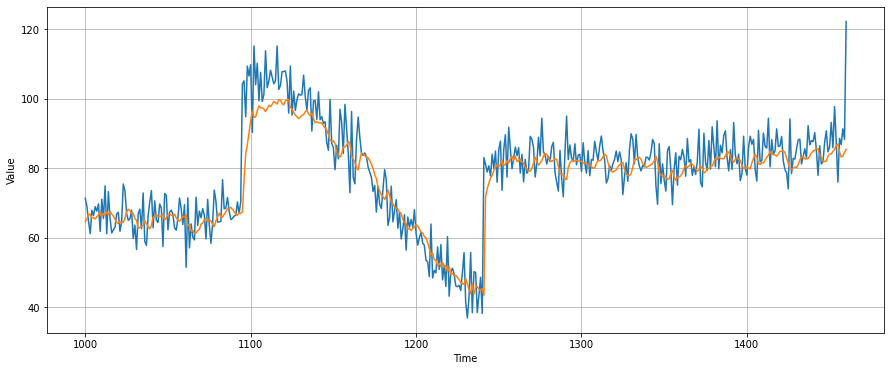

In [0]:
# Prediction of all elements of the validation set:

# Calculating predictions by picking up slices of window_size each time:
forecast = model_forecast(model, series[..., np.newaxis], window_size)   # remember that we need to expand the dim of the dataset. Here we use np.newaxis

print(len(forecast))
print(forecast[:2])

# Getting the predictions of the validation set only
forecast = forecast[time_split-window_size:-1, -1, 0]  # !!! Careful here!!! -> the predictions index are shifted by window_size
                                                       # us this if we carry all the sequences from the LSTM (return_sequences=True on all the LSTM layers). as you want only the last time step.
# forecast = forecast[time_split-window_size:-1, 0, 0]   # us this if we carry only the last time step from the LSTM (no return_sequences=True on the last LSTM). as it outputs only the last and only time step.                                                   
results = forecast # np.array(forecast)[:,0,0]  

plt.figure(figsize=(15,6))

plot_series(time_val, x_val)
plot_series(time_val, results)
plt.show()

In [0]:
# Prediction statistical Metrics:

print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())



47.20338
5.0248265


In [0]:
# Forecasts for all validation set:

print(results)